In [1]:
import os
import sys
import numpy as np
import re
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf

In [5]:
img_shape = 256
img_channels = 3

In [6]:
def load_data(imgPath = None, maskPath = None, shape = 256):
    imgNames = os.listdir(imgPath)
    maskNames = []
    
    
    imgAddr = imgPath + '/'
    maskAddr = maskPath + '/'
    img_list = []
    mask_list =[]
    
    for i in range (len(imgNames)):
        try:
            img = plt.imread(imgAddr + imgNames[i]) 
            mask = plt.imread(maskAddr + imgNames[i])
            
        except:
            continue
        img = cv2.resize(img, (shape, shape))
        mask = cv2.resize(mask, (shape, shape))
        img_list.append(img)
        mask_list.append(mask) # this is because its a binary mask and img is present in channel 0
    
    return img_list,mask_list

In [ ]:
image_dir = 'images_1024'
mask_dir = 'masks_1024'
#image_dir = 'C:/Users/yashc/Downloads/Glomeruli Dataset/train_image'
#mask_dir = 'C:/Users/yashc/Downloads/Glomeruli Dataset/train_mask'
img_list,mask_list=load_data(image_dir,mask_dir,img_shape)

In [1]:
dataset = tf.data.Dataset.from_tensor_slices((img_list, mask_list))

# Batch and shuffle the dataset
batch_size = 32
dataset = dataset.shuffle(buffer_size=len(img_list))
dataset = dataset.batch(batch_size)

NameError: name 'tf' is not defined

In [2]:
# defining Conv2d block for our u-net
# this block essentially performs 2 convolution

def Conv2dBlock(inputTensor, numFilters, kernelSize = 3, doBatchNorm = True):
    #first Conv
    x = tf.keras.layers.Conv2D(filters = numFilters, kernel_size = (kernelSize, kernelSize),
                              kernel_initializer = 'he_normal', padding = 'same') (inputTensor)
    
    if doBatchNorm:
        x = tf.keras.layers.BatchNormalization()(x)
        
    x =tf.keras.layers.Activation('relu')(x)
    
    #Second Conv
    x = tf.keras.layers.Conv2D(filters = numFilters, kernel_size = (kernelSize, kernelSize),
                              kernel_initializer = 'he_normal', padding = 'same') (x)
    if doBatchNorm:
        x = tf.keras.layers.BatchNormalization()(x)
        
    x = tf.keras.layers.Activation('relu')(x)
    
    return x



# Now defining Unet 
def GiveMeUnet(inputImage, numFilters = 16, droupouts = 0.1, doBatchNorm = True):
    # defining encoder Path
    c1 = Conv2dBlock(inputImage, numFilters * 1, kernelSize = 3, doBatchNorm = doBatchNorm)
    p1 = tf.keras.layers.MaxPooling2D((2,2))(c1)
    p1 = tf.keras.layers.Dropout(droupouts)(p1)
    
    c2 = Conv2dBlock(p1, numFilters * 2, kernelSize = 3, doBatchNorm = doBatchNorm)
    p2 = tf.keras.layers.MaxPooling2D((2,2))(c2)
    p2 = tf.keras.layers.Dropout(droupouts)(p2)
    
    c3 = Conv2dBlock(p2, numFilters * 4, kernelSize = 3, doBatchNorm = doBatchNorm)
    p3 = tf.keras.layers.MaxPooling2D((2,2))(c3)
    p3 = tf.keras.layers.Dropout(droupouts)(p3)
    
    c4 = Conv2dBlock(p3, numFilters * 8, kernelSize = 3, doBatchNorm = doBatchNorm)
    p4 = tf.keras.layers.MaxPooling2D((2,2))(c4)
    p4 = tf.keras.layers.Dropout(droupouts)(p4)
    
    c5 = Conv2dBlock(p4, numFilters * 16, kernelSize = 3, doBatchNorm = doBatchNorm)
    p5 = tf.keras.layers.MaxPooling2D((2,2))(c5)
    p5 = tf.keras.layers.Dropout(droupouts)(p5)

    b = Conv2dBlock(p5, numFilters * 32, kernelSize = 3, doBatchNorm = doBatchNorm)
    # defining decoder path
    u6 = tf.keras.layers.Conv2DTranspose(numFilters*16, (3, 3), strides=(2, 2), padding='same')(b)
    u6 = tf.keras.layers.concatenate([u6, c5])
    u6 = tf.keras.layers.Dropout(droupouts)(u6)
    c6 = Conv2dBlock(u6, numFilters * 16, kernelSize=3, doBatchNorm=doBatchNorm)
    
    u7 = tf.keras.layers.Conv2DTranspose(numFilters*8, (3, 3), strides=(2, 2), padding='same')(c6)
    u7 = tf.keras.layers.concatenate([u7, c4])
    u7 = tf.keras.layers.Dropout(droupouts)(u7)
    c7 = Conv2dBlock(u7, numFilters * 8, kernelSize=3, doBatchNorm=doBatchNorm)
    
    u8 = tf.keras.layers.Conv2DTranspose(numFilters*4, (3, 3), strides=(2, 2), padding='same')(c7)
    u8 = tf.keras.layers.concatenate([u8, c3])
    u8 = tf.keras.layers.Dropout(droupouts)(u8)
    c8 = Conv2dBlock(u8, numFilters * 4, kernelSize=3, doBatchNorm=doBatchNorm)
    
    u9 = tf.keras.layers.Conv2DTranspose(numFilters*2, (3, 3), strides=(2, 2), padding='same')(c8)
    u9 = tf.keras.layers.concatenate([u9, c2])
    u9 = tf.keras.layers.Dropout(droupouts)(u9)
    c9 = Conv2dBlock(u9, numFilters * 2, kernelSize=3, doBatchNorm=doBatchNorm)
    
    u10 = tf.keras.layers.Conv2DTranspose(numFilters*1, (3, 3), strides=(2, 2), padding='same')(c9)
    u10 = tf.keras.layers.concatenate([u10, c1])
    u10 = tf.keras.layers.Dropout(droupouts)(u10)
    c10 = Conv2dBlock(u10, numFilters * 1, kernelSize=3, doBatchNorm=doBatchNorm)
    output = tf.keras.layers.Conv2D(1, (1, 1), activation = 'sigmoid')(c10)
    model = tf.keras.Model(inputs = [inputImage], outputs = [output])
    return model


In [4]:
## instanctiating model
inputs = tf.keras.layers.Input((img_shape, img_shape, 3))
unet = GiveMeUnet(inputs, droupouts= 0.1)
unet.compile(optimizer = 'Adam', loss = 'binary_crossentropy', metrics = ['accuracy'] )

NameError: name 'img_shape' is not defined

In [ ]:
retVal = unet.fit(dataset,batch_size=32, epochs = 10, verbose = 1)

In [35]:
loaded_model =tf.keras.models.load_model("unet_new2/unet_new2_32B_50E_16F.keras")

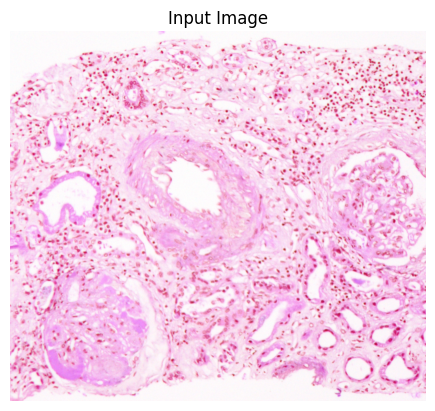

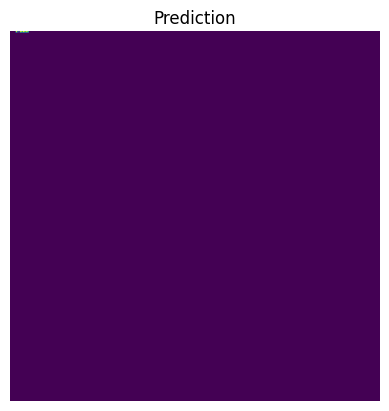

In [49]:
#input_images = cv2.imread("C:/Users/yashc/Downloads/Glomeruli Dataset/train_image/SAS_21883_001_9.png") 
input_images = cv2.imread("b.jpg") 
#resized_image = tf.image.resize(image, (256, 256)) 
#predictions = loaded_model.predict(resized_image) 
preprocessed_images = [tf.image.resize(input_images, (256, 256))]

# Convert the preprocessed images to a NumPy array
input_data = tf.convert_to_tensor(preprocessed_images)

# Make predictions using the model
#predictions = unet.predict(input_data)
predictions = loaded_model.predict(input_data)

plt.imshow(input_images) 
plt.title('Input Image') 
plt.axis('off')
plt.show()
plt.imshow(predictions[0]) 
plt.title('Prediction') 
plt.axis('off')

plt.show()

In [50]:
min(predictions)

array([[[2.7614855e-25],
        [1.3338652e-25],
        [1.4559981e-06],
        ...,
        [0.0000000e+00],
        [0.0000000e+00],
        [0.0000000e+00]],

       [[6.4177578e-32],
        [2.6215897e-27],
        [1.3753241e-26],
        ...,
        [0.0000000e+00],
        [0.0000000e+00],
        [0.0000000e+00]],

       [[2.4552871e-36],
        [4.4069217e-24],
        [0.0000000e+00],
        ...,
        [0.0000000e+00],
        [0.0000000e+00],
        [0.0000000e+00]],

       ...,

       [[0.0000000e+00],
        [0.0000000e+00],
        [0.0000000e+00],
        ...,
        [0.0000000e+00],
        [0.0000000e+00],
        [0.0000000e+00]],

       [[0.0000000e+00],
        [0.0000000e+00],
        [0.0000000e+00],
        ...,
        [0.0000000e+00],
        [0.0000000e+00],
        [0.0000000e+00]],

       [[0.0000000e+00],
        [0.0000000e+00],
        [0.0000000e+00],
        ...,
        [0.0000000e+00],
        [0.0000000e+00],
        [0.0000000e+00]]

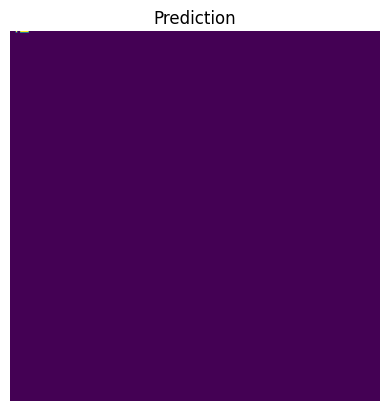

In [52]:
threshold = 0.5
thresholded_array = (predictions >= threshold).astype(float)
thresholded_array
plt.imshow(thresholded_array[0]) 
plt.title('Prediction') 
plt.axis('off')
plt.show()

In [22]:
loaded_model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_19 (Conv2D)              (None, 256, 256, 16) 448         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_18 (BatchNo (None, 256, 256, 16) 64          conv2d_19[0][0]                  
__________________________________________________________________________________________________
activation_18 (Activation)      (None, 256, 256, 16) 0           batch_normalization_18[0][0]     
_______________________________________________________________________________________